<a href="https://colab.research.google.com/github/Dernibes/SpeakerRecognitionGroupProject/blob/main/GroupProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

# Dependencies

In [ ]:
# !pip install -U scipy (Don't think we need this)
# !pip install -q tflite-model-maker (Don't think we need this)

In [2]:
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy import signal
from scipy.signal import spectrogram

import pandas as pd
import os
import numpy as np
from os.path import exists

import pathlib

import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import shutil

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Spectogram (experiment code)

In [ ]:
# Reading multiple .wav files 
CSV_FILE_PATH = "/content/drive/Speech"  # CSV file storing data on .wav files
DATA_PATH = "/content/drive/" # path to folder

df = pd.read_csv(CSV_FILE_PATH)

FileNotFoundError: ignored

In [ ]:
rate, x = wavfile.read('Trial.wav')
print(rate)

FileNotFoundError: ignored

NameError: ignored

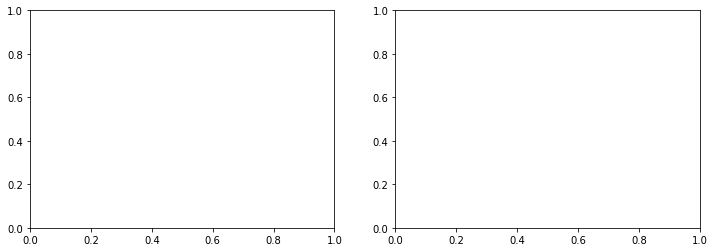

In [ ]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(x); ax1.set_title('Raw audio signal')
#ax2.specgram(x); ax2.set_title('Spectrogram');
#ax2.specgram(x[:,0],plt.specgram(x[:,0], Fs=0.1, xextent=(0,30)))
plt.specgram(x[:,0], Fs=0.1, xextent=(0,30))


In [ ]:
import librosa 
import librosa.display

filename = 
librosa_audio, librosa_sample_rate = librosa.load(filename, sr=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(librosa_audio); 
ax1.set_title('Raw audio signal')

X = librosa.stft(librosa_audio)
Xdb = librosa.amplitude_to_db(numpy.abs(X), ref=numpy.max)
img = librosa.display.specshow(Xdb, sr=librosa_sample_rate, x_axis='time', y_axis='hz')
ax2.set(title='Linear-frequency power spectrogram')
fig.colorbar(img, format="%+2.f dB")

print(librosa_audio.shape)
print(X.shape)

[  6590976   8153344   8965120 ... 260170240 285201408 309839872]


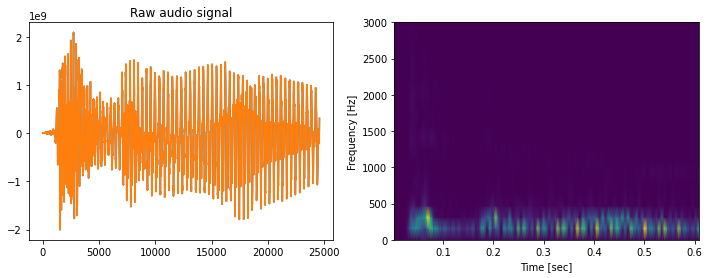

In [ ]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(x); ax1.set_title('Raw audio signal')

#ax2.specgram(x); ax2.set_title('Spectrogram');#

print(x[:,0])

# ax2.specgram(x[:,0],spectrogram(x[:,0], 100000))

f, t, Sxx = spectrogram(x[:,0], 40e3)

plt.pcolormesh(t, f, Sxx, shading='gouraud')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.ylim((0, 3000))

plt.savefig('/content/drive/Speech/Spectogram_Images/foo.png', bbox_inches='tight') # Saving as PNG file

plt.show()

# TF AUDIO RECOGNITION TUTORIAL
https://www.tensorflow.org/tutorials/audio/simple_audio

# 新段落

Basically just copied the tutorial code and checked it works well (didn't take long haha). 
Was thinking we could use the structure and code for our purpose:

The tutorial is about learning the commands: ['left' 'go' 'up' 'yes' 'stop' 'down' 'right' 'no'] but I think we can change this (and still use the dataset) for our task. 

So for example as a start, we record each of us saying "yes" and combine it with the "yes" public dataset and change the labels so the model learns our voices instead of the commands? The preprocessing, loading the data etc is the same and it uses TF tensors which I think is easier for compatability with model training than scipy.

The recordings are 1s long, and we can start using Seb's recording script as a start?

## Loading Waveforms

In [ ]:
# Downloading Speech Commands dataset

DATASET_PATH = '/content/data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  file_path = tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 2s 0us/step


In [ ]:
# Formatting dataset

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != "README.md"]
print("Commands: ", commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print("Number of total examples: ", num_samples)
print("Number of examples per label: ", len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Commands:  ['left' 'stop' 'down' 'up' 'no' 'yes' 'go' 'right']
Number of total examples:  8000
Number of examples per label:  1000


In [ ]:
# Creating train, val and test files

train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8) : int(num_samples+num_samples*0.1)]
test_files = filenames[int(-num_samples*0.1) :]


# Example audio
test_file = tf.io.read_file(DATASET_PATH+"/down/0a9f9af7_nohash_0.wav")
test_audio, _ = tf.audio.decode_wav(contents=test_file)
print(test_audio.shape)
print(len(train_files), len(val_files), len(test_files))

(13654, 1)
6400 1600 800


## Visualising Waveforms

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)
 
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

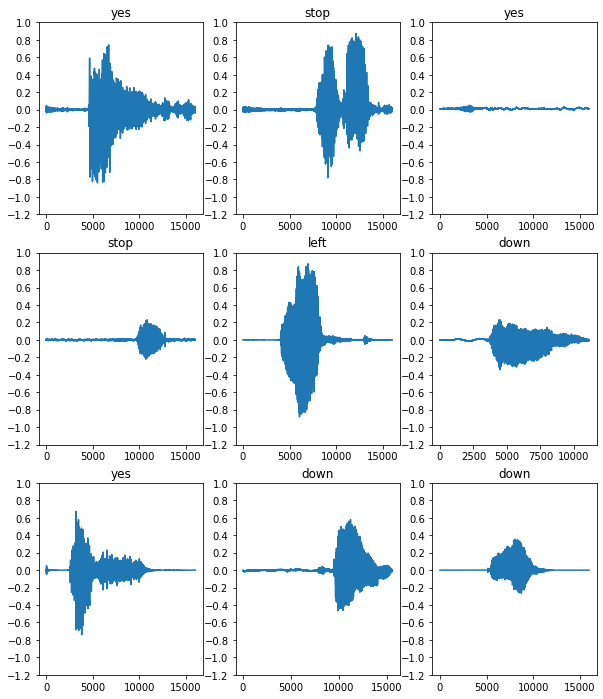

In [ ]:
# Plotting some waveforms
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectogram

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


## Visualising Spectogram

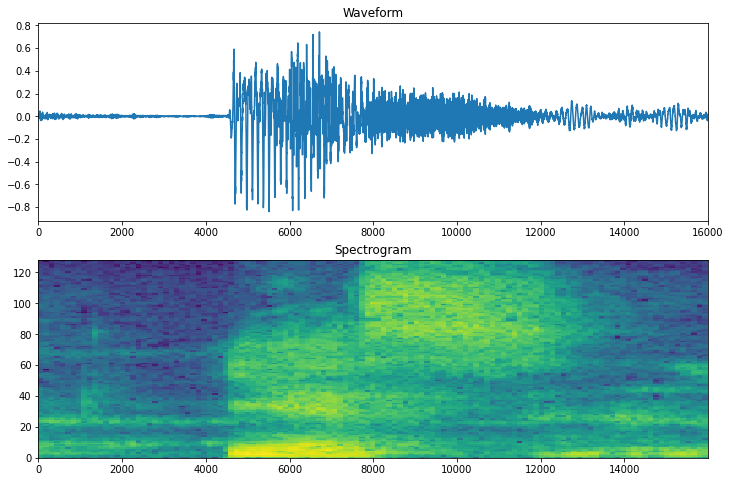

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

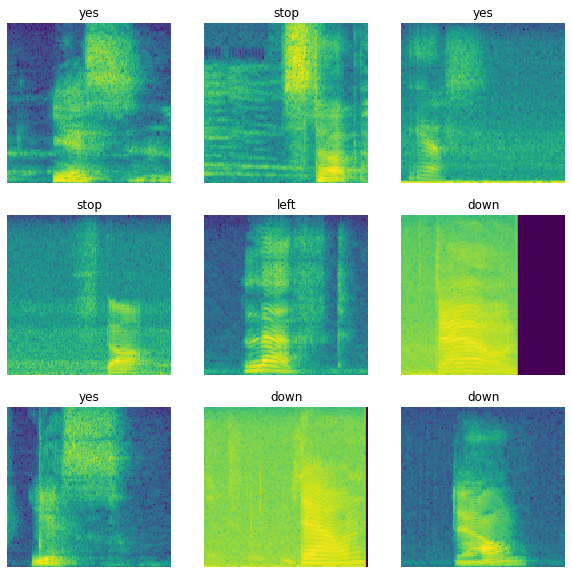

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Val and Test Preprocessing

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Reduce latency
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


## Model Definition

In [ ]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

## Model Training

In [ ]:
# Training here

## Model Testing

In [ ]:
# Testing here

# BASELINE SOLUTION

## Getting Group Data

In [3]:
# Add our recordings to the data directory
# The data should be in zipped format 
!git clone -q --depth 1 https://github.com/Dernibes/SpeakerRecognitionGroupProject.git
%cd SpeakerRecognitionGroupProject/TrainingDataGen
!pwd

/content/SpeakerRecognitionGroupProject/TrainingDataGen
/content/SpeakerRecognitionGroupProject/TrainingDataGen


In [4]:
names = ["Xixian", "Adam", "Ibrahim", "Riccardo", "Seb"]
GROUP_DATA_DIR = "/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training"

# Unzipping data
!unzip /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Adam
!unzip /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim
!unzip /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Riccardo
!unzip /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Seb
!unzip /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Xixian

unzip:  cannot find or open /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Adam, /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Adam.zip or /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Adam.ZIP.
unzip:  cannot find or open /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim, /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim.zip or /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim.ZIP.
unzip:  cannot find or open /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Riccardo, /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Riccardo.zip or /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Riccardo.ZIP.
unzip:  cannot find or open /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Seb, /content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Seb.zip or /content/SpeakerRecognitionGroupProject/TrainingData

In [5]:
# Storing waveforms paths under group filenames
filenames = tf.io.gfile.glob(GROUP_DATA_DIR + '/*/*')

num_samples = len(filenames)
print("num_samples: ", num_samples)

num_samples:  100


## OPTIONAL: Combining with Public dataset

In [ ]:
# Downloading Speech Commands dataset

DATASET_PATH = '/content/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  file_path = tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  
# Deleting folders except yes

commands = ["down", "go", "left", "no", "right", "stop", "up"]

down_dir = pathlib.Path(DATASET_PATH+"/down")

if down_dir.exists():
  for i in commands:
    shutil.rmtree('/content/data/mini_speech_commands/' + i)


# Rename "yes" folder to "yes_other"
os.rename(DATASET_PATH+"/yes", DATASET_PATH+"/yes_other")

182091776/182082353 [==============================] - 1s 0us/step


FileNotFoundError: ignored

In [ ]:
# Formatting Public dataset

public_filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
public_filenames = tf.random.shuffle(public_filenames)
num_public_samples = len(public_filenames)

print("Number of Public examples: ", num_public_samples)

Number of Public examples:  0


In [ ]:
# Combining with group dataset
# Set combine = True to combine with public dataset
combine = True

if combine:
  filenames += public_filenames
  num_samples += num_public_samples

InvalidArgumentError: ignored

## Train, Val and Test sets

Changed split to before shuffles.

Shuffles each persons folder individually and splits that for train/val/test.

Compiles into main train/val/test tensors.

Proposed below.

In [ ]:

train_files = []
val_files = []
test_files = []

for i in range(len(names)):
  filenamestemp=tf.io.gfile.glob(GROUP_DATA_DIR + '/'+names[i]+'/*')
  filenamestemp = tf.random.shuffle(filenamestemp)
  num_samplestemp = len(filenamestemp)

  train_filestemp = filenamestemp[:int(num_samplestemp*0.8)]
  val_filestemp = filenamestemp[int(num_samplestemp*0.8) : int(num_samplestemp*0.9)]
  test_filestemp = filenamestemp[int(-num_samplestemp*0.1) :]

  train_files=tf.concat([train_files,train_filestemp],0)
  val_files=tf.concat([val_files,val_filestemp],0)
  test_files=tf.concat([test_files,test_filestemp],0)

train_files = tf.random.shuffle(train_files)
val_files = tf.random.shuffle(val_files)
test_files = tf.random.shuffle(test_files)

print('Training Files\n',train_files,'\n')
print('Validation Files\n',val_files,'\n')
print('Test Files\n',test_files,'\n')

# Example audio
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
print(test_audio.shape)
print(len(train_files), len(val_files), len(test_files))


In [6]:
"""
# Creating train, val and test files

# Shuffle data
filenames = tf.random.shuffle(filenames)
print(filenames)

# Split into train, val and test
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8) : int(num_samples*0.9)]
test_files = filenames[int(-num_samples*0.1) :]

print(test_files)

# Example audio
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
print(test_audio.shape)
print(len(train_files), len(val_files), len(test_files))
"""

tf.Tensor(
[b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Seb/Seb_Hello_5.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Xixian/Xixian_Hello_9.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim/Ibrahim_Hello_8.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Seb/Seb_Hello_2.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim/Ibrahim_Hello_6.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Seb/Seb_Hello_12.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Xixian/Xixian_Hello_6.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Xixian/Xixian_Hello_5.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim/Ibrahim_Hello_17.wav'
 b'/content/SpeakerRecognitionGroupProject/TrainingDataGen/Training/Ibrahim/Ibrahim_Hello_16.wav'
 b'/content/SpeakerRecognitionGroupProject/Tra

## Decoding audio

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

train_files_numpy = train_files.numpy()

## Visualising some data

FailedPreconditionError: ignored

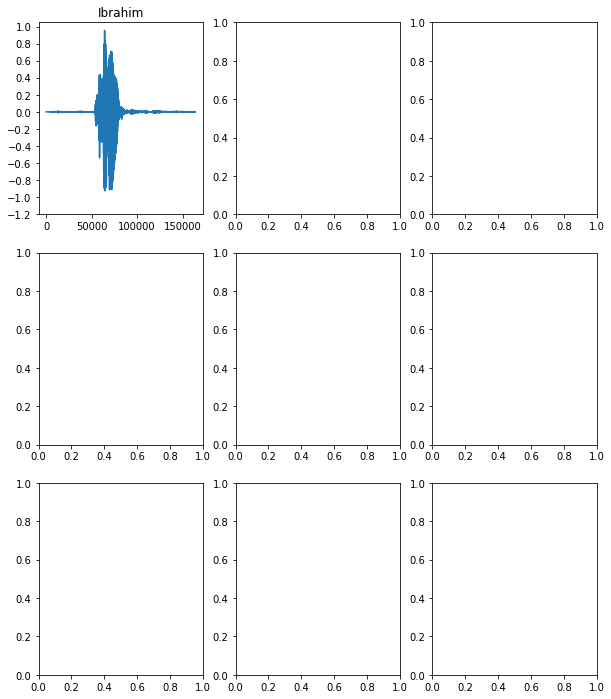

In [ ]:
# Plotting some waveforms
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectogram 

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes_other
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


## Visualising Spectogram

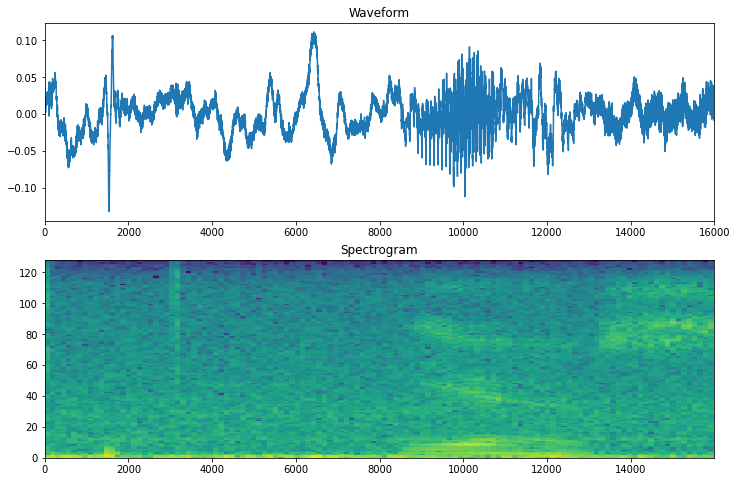

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

## Val and Test Set Preprocessing

## Model Definition

## Model Training

## Model Testing